In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report, precision_recall_curve, auc, matthews_corrcoef
from sklearn.pipeline import Pipeline

from imblearn.over_sampling import SMOTE

from tqdm import tqdm

Using TensorFlow backend.


In [2]:
train_df = pd.read_csv('../Data/2020-train.csv')

In [3]:
train_df.head()

,pitcher_id,pitcher_side,batter_id,batter_side,stadium_id,umpire_id,catcher_id,inning,top_bottom,outs,...,zone_speed,vert_approach_angle,horz_approach_angle,zone_time,x55,y55,z55,pitch_type,pitch_call,pitch_id
0,d7e3acce,Right,32678d8d,Right,a4833794,f88d09f4,83cdf9ff,3,1,0.0,...,86.024200,-4.37258,1.429580,0.404622,-0.059343,55,6.03322,FA,InPlay,42fce2f6
1,44ec1bf5,Right,81d51733,Left,f60d6ea5,b67d862c,a126f66f,6,2,0.0,...,89.458199,-4.90467,-2.148410,0.385719,-2.148680,55,6.23380,FA,InPlay,3e9cda86
2,44d87ee6,Left,8eefccb7,Right,a9b8b538,13993d26,9db4e46f,5,2,2.0,...,75.593597,-6.00728,-0.122044,0.463953,1.300450,55,6.14750,CH,BallCalled,f129a6cd
3,ff6adae0,Right,8f8ab5af,Right,e569ec39,0d8ba4bb,bbbfd290,5,1,2.0,...,76.396400,-9.50640,-2.581980,0.458471,-1.659590,55,6.60043,CU,InPlay,03e9bc05
4,c70c96e5,Right,10874746,Right,a5ce1bf6,94a4c552,75087ec8,8,1,2.0,...,83.215302,-4.53233,-0.268188,0.415965,-1.526170,55,4.77332,FA,StrikeCalled,48feb675


In [4]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 582205 entries, 0 to 582204
Data columns (total 36 columns):
pitcher_id             582205 non-null object
pitcher_side           582205 non-null object
batter_id              582205 non-null object
batter_side            582205 non-null object
stadium_id             582205 non-null object
umpire_id              582205 non-null object
catcher_id             582205 non-null object
inning                 582205 non-null int64
top_bottom             582205 non-null int64
outs                   582053 non-null float64
balls                  582205 non-null int64
strikes                582205 non-null int64
release_speed          582093 non-null float64
vert_release_angle     582093 non-null float64
horz_release_angle     582093 non-null float64
spin_rate              573194 non-null float64
spin_axis              582093 non-null float64
tilt                   580953 non-null object
rel_height             582093 non-null float64
rel_side    

## Data Cleaning

First let's get rid of the null values floating around in the data set. There are a total of 582,205 entries in the initial data set, some columns are full but some columns have null values in it. Starting with release speed, it does not seem like there are many null values, let's take a look.

In [5]:
train_df[train_df['release_speed'].isnull()]

,pitcher_id,pitcher_side,batter_id,batter_side,stadium_id,umpire_id,catcher_id,inning,top_bottom,outs,...,zone_speed,vert_approach_angle,horz_approach_angle,zone_time,x55,y55,z55,pitch_type,pitch_call,pitch_id
3405,8759809c,Right,00bde845,Right,80756f45,9c6cbb5e,9c6cbb5e,5,2,0.0,...,NaN,NaN,NaN,NaN,NaN,55,NaN,NaN,StrikeCalled,1d66612a
12334,f6d227a5,Right,69426d29,Left,a3f610ed,9c6cbb5e,9c6cbb5e,5,2,2.0,...,NaN,NaN,NaN,NaN,NaN,55,NaN,NaN,InPlay,beb842a8
13895,b74a40d9,Right,00bde845,Right,a3f610ed,9c6cbb5e,9c6cbb5e,3,1,1.0,...,NaN,NaN,NaN,NaN,NaN,55,NaN,NaN,InPlay,e271ef9d
16260,47032f76,Left,20bf9444,Right,c9712626,9c6cbb5e,9c6cbb5e,16,2,1.0,...,NaN,NaN,NaN,NaN,NaN,55,NaN,FA,InPlay,49f26761
17008,96a1cebe,Right,76c0475e,Right,a5ce1bf6,9c6cbb5e,9c6cbb5e,9,2,0.0,...,NaN,NaN,NaN,NaN,NaN,55,NaN,SL,BallCalled,ca8c6341
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
564267,b3336756,Left,bbbfd290,Right,9b5daeaf,9c6cbb5e,9c6cbb5e,9,1,2.0,...,NaN,NaN,NaN,NaN,NaN,55,NaN,CH,InPlay,8d21a585
564950,c3ededfb,Right,8f8ab5af,Right,b20853fa,9c6cbb5e,9c6cbb5e,1,1,2.0,...,NaN,NaN,NaN,NaN,NaN,55,NaN,NaN,BallCalled,142a06b3
567947,ad6bf2a7,Right,066e327d,Right,fe6b0f40,9c6cbb5e,9c6cbb5e,5,2,0.0,...,NaN,NaN,NaN,NaN,NaN,55,NaN,NaN,StrikeCalled,5326a5f6
571936,0a606b2d,Right,336a9f05,Left,1a39a252,9c6cbb5e,9c6cbb5e,9,1,1.0,...,NaN,NaN,NaN,NaN,NaN,55,NaN,NaN,BallCalled,3c4e2fe4


Only 112, I feel comfortable dropping these and it not affecting the integrity of the data.

In [6]:
train_df = train_df.drop(train_df[train_df['release_speed'].isnull()].index)
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 582093 entries, 0 to 582204
Data columns (total 36 columns):
pitcher_id             582093 non-null object
pitcher_side           582093 non-null object
batter_id              582093 non-null object
batter_side            582093 non-null object
stadium_id             582093 non-null object
umpire_id              582093 non-null object
catcher_id             582093 non-null object
inning                 582093 non-null int64
top_bottom             582093 non-null int64
outs                   581941 non-null float64
balls                  582093 non-null int64
strikes                582093 non-null int64
release_speed          582093 non-null float64
vert_release_angle     582093 non-null float64
horz_release_angle     582093 non-null float64
spin_rate              573194 non-null float64
spin_axis              582093 non-null float64
tilt                   580953 non-null object
rel_height             582093 non-null float64
rel_side    

Now let's take a look at outs. Again, not many null values in it, let's see how many there are.

In [7]:
train_df[train_df['outs'].isnull()]

,pitcher_id,pitcher_side,batter_id,batter_side,stadium_id,umpire_id,catcher_id,inning,top_bottom,outs,...,zone_speed,vert_approach_angle,horz_approach_angle,zone_time,x55,y55,z55,pitch_type,pitch_call,pitch_id
6689,a6118212,Right,5dce2d1c,Right,99faafae,c16da957,fd37f21c,7,1,NaN,...,75.911797,-10.27540,-1.215380,0.457509,-1.44079,55,6.19782,SL,StrikeSwinging,8f7e287a
14410,5b740fab,Left,e2e2a336,Right,d0e0eb76,c9752165,5a42193e,5,2,NaN,...,72.887398,-7.79636,0.764407,0.476133,3.30888,55,5.70064,CH,BallCalled,fdaab946
19161,161160dd,Right,f338e9d3,Left,1a39a252,c229ef9e,41ac8158,4,2,NaN,...,84.766296,-5.21754,0.053372,0.417402,-1.30256,55,5.76697,FA,BallCalled,479ee407
23843,f6d227a5,Right,e9553a98,Right,d0e0eb76,26a1bb6b,0ffec018,6,1,NaN,...,74.321999,-9.18817,-4.715870,0.470084,-2.66638,55,6.70092,CH,StrikeSwinging,b01234ef
27156,264562c6,Right,29d12af7,Left,a5ce1bf6,9806dfbc,a3a2988b,11,2,NaN,...,86.122299,-7.29354,-4.722650,0.411571,-2.93787,55,6.37265,SL,StrikeSwinging,f7771432
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
559476,b3d5c0a9,Right,cf690f2f,Left,0c59f5af,8f1ef267,fa18ff59,5,2,NaN,...,80.375298,-7.07432,-2.223690,0.430519,-1.15777,55,6.08150,SL,FoulBall,d29aa13d
569804,91700130,Right,de9d396f,Left,99faafae,667d5752,41ac8158,7,1,NaN,...,84.243103,-5.38618,0.594491,0.419565,-1.64532,55,6.31180,FA,BallCalled,d711100f
569836,91700130,Right,de9d396f,Left,99faafae,667d5752,41ac8158,7,1,NaN,...,82.846298,-6.36660,-1.029200,0.425654,-1.62191,55,6.24978,FA,StrikeCalled,5f05e674
570351,d5ef78cb,Right,781ec6be,Right,aa998b21,a9ad7586,a3a2988b,6,1,NaN,...,85.266098,-4.60246,-1.696110,0.401914,-1.92533,55,5.80506,FA,StrikeSwinging,24ac5f78


Only 152, that's good. I'll drop these as well since there's no real way to know how many outs there were on a given pitch.

In [8]:
train_df = train_df.drop(train_df[train_df['outs'].isnull()].index)
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 581941 entries, 0 to 582204
Data columns (total 36 columns):
pitcher_id             581941 non-null object
pitcher_side           581941 non-null object
batter_id              581941 non-null object
batter_side            581941 non-null object
stadium_id             581941 non-null object
umpire_id              581941 non-null object
catcher_id             581941 non-null object
inning                 581941 non-null int64
top_bottom             581941 non-null int64
outs                   581941 non-null float64
balls                  581941 non-null int64
strikes                581941 non-null int64
release_speed          581941 non-null float64
vert_release_angle     581941 non-null float64
horz_release_angle     581941 non-null float64
spin_rate              573044 non-null float64
spin_axis              581941 non-null float64
tilt                   580802 non-null object
rel_height             581941 non-null float64
rel_side    

Now let's take a look at spin rate. It certainly looks like there are a lot of data points missing in this column, so dropping all the values may not be the best idea. Let's see how many there are.

In [9]:
train_df[train_df['spin_rate'].isnull()]

,pitcher_id,pitcher_side,batter_id,batter_side,stadium_id,umpire_id,catcher_id,inning,top_bottom,outs,...,zone_speed,vert_approach_angle,horz_approach_angle,zone_time,x55,y55,z55,pitch_type,pitch_call,pitch_id
43,4c807a49,Left,210e8d5b,Right,402559d3,4ff102e5,fbc0970f,6,2,2.0,...,77.869301,-6.96547,2.47110,0.444589,2.32704,55,5.75515,SL,InPlay,1769b4d5
148,cb113772,Right,96339e13,Left,aa998b21,c683b9a6,a3a2988b,7,1,0.0,...,73.582497,-9.61581,-2.45899,0.474079,-1.42864,55,5.84820,SL,BallCalled,ef2a6b0e
161,af6d3149,Right,6c43d395,Right,03722f5d,d057fd71,e9aa50df,9,1,1.0,...,76.742798,-6.86927,-3.62681,0.461172,-3.17556,55,4.88357,SL,StrikeCalled,f31fc865
237,eccb6087,Right,08b0b39d,Left,a5ce1bf6,9806dfbc,b1499101,9,1,1.0,...,79.280602,-6.75395,-3.49224,0.438489,-1.96139,55,5.75645,SL,StrikeCalled,3588e119
304,e332e67d,Right,34a8f234,Left,402559d3,fbbea103,e4fac104,5,2,2.0,...,80.649803,-8.90885,-2.33627,0.433380,-1.18638,55,6.42062,SL,InPlay,6fa4b697
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
581856,00f5fb90,Right,b4efd4bf,Right,f682daed,cac8185e,e4fac104,4,2,1.0,...,77.819801,-8.53157,-2.76430,0.446821,-2.01818,55,5.79492,SL,InPlay,fc151903
581859,fa9b0925,Right,c1ec06e6,Right,5025d8df,7675ce83,054f7d9f,6,1,0.0,...,77.702797,-10.84580,-3.94847,0.452332,-1.45562,55,6.02164,CU,BallCalled,941e91ca
581927,09da5d7a,Left,073c2b16,Right,b20853fa,4db7bcbc,9db4e46f,9,1,0.0,...,76.172997,-8.79066,3.64529,0.459917,2.00739,55,6.51264,SL,StrikeSwinging,3f7dd184
581992,be5181f0,Right,566220c7,Right,03722f5d,a86853a2,5b8927f6,2,2,2.0,...,77.229103,-7.42066,-3.82928,0.458138,-1.49327,55,5.40118,SL,StrikeSwinging,40cc471a


Almost 9000 rows. Dropping that many data points could have an adverse effect on the data set and any potential modeling we do. Let's take a look at a countplot and see the distribution of the spin rate column.

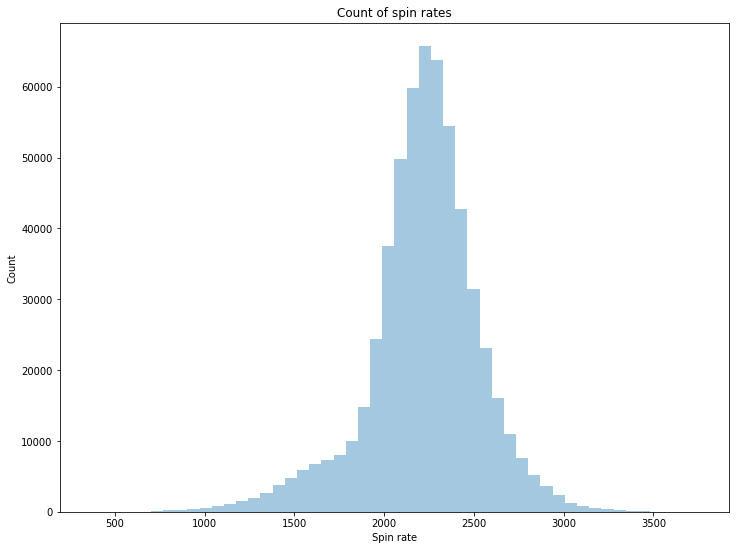

In [10]:
plt.figure(figsize=(12,9))
sns.distplot(train_df[train_df['spin_rate'].notnull()]['spin_rate'], hist=True, kde=False)
plt.xlabel('Spin rate')
plt.ylabel('Count')
plt.title('Count of spin rates')
plt.show()

It's normally distributed, which is expected from this type of data. Filling the missing values with the average would be the best way to go. That keeps the normal distribution of this variable intact and shouldn't have any adverse effect on any future modeling.

In [11]:
train_df['spin_rate'].describe()

count    573044.000000
mean       2220.693335
std         311.989506
min         362.382996
25%        2072.879883
50%        2238.449951
75%        2400.790039
max        3752.239990
Name: spin_rate, dtype: float64

In [12]:
train_df['spin_rate'].fillna(train_df['spin_rate'].mean(), inplace=True)

In [13]:
train_df['spin_rate'].describe()

count    581941.000000
mean       2220.693335
std         309.595392
min         362.382996
25%        2076.080078
50%        2233.979980
75%        2397.649902
max        3752.239990
Name: spin_rate, dtype: float64

Tilt is the next column to have missing values, let's take a look at how many.

In [14]:
train_df[train_df['tilt'].isnull()]

,pitcher_id,pitcher_side,batter_id,batter_side,stadium_id,umpire_id,catcher_id,inning,top_bottom,outs,...,zone_speed,vert_approach_angle,horz_approach_angle,zone_time,x55,y55,z55,pitch_type,pitch_call,pitch_id
378,cd483725,Right,192899a6,Right,c9712626,1869cf54,00ae6fb5,3,1,1.0,...,73.954399,-9.60881,-1.961030,0.477100,-1.181070,55,6.13692,CU,InPlay,d30f5214
770,22b76a09,Left,d11080ae,Left,5025d8df,598ea1b2,a421b54b,3,2,0.0,...,67.967903,-11.73220,1.604870,0.512340,1.140470,55,6.32628,CU,BallCalled,a7209bc8
1339,cd483725,Right,deb2ab32,Right,0b15e1ca,eb059a22,00ae6fb5,6,2,1.0,...,75.172897,-9.79158,-1.867760,0.471512,-0.749778,55,5.86303,CU,StrikeSwinging,6b05ddc4
2117,28e273c4,Left,4ac005f3,Right,d0d69f32,46051258,4fedda83,3,1,1.0,...,75.375900,-8.49879,2.576980,0.459569,2.623400,55,6.40245,CU,InPlay,3face29a
3399,193d153f,Left,ed874f19,Right,c9712626,eb059a22,4f9cd7f9,4,1,2.0,...,75.718102,-9.39808,2.573850,0.462214,2.150780,55,6.07629,CU,StrikeSwinging,e1c3703d
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
580815,98eaf8b2,Right,f57085ec,Right,99faafae,373947e5,ccd72da8,9,2,2.0,...,79.889999,-8.93767,-1.194220,0.435881,-1.759100,55,6.48687,CU,StrikeSwinging,672aa57b
581637,44ec1bf5,R,b3dac04c,L,cfe02944,aea4dd5a,a126f66f,6,2,1.0,...,88.644798,-5.31458,-2.812660,0.390148,-2.398420,55,6.25742,FA,BallCalled,9e8fb97a
581716,60a6f8df,Right,cddcbd8f,Left,0faa3b2d,4581c636,a421b54b,7,1,0.0,...,79.617599,-6.18068,-2.975590,0.435664,-2.043060,55,5.01476,SL,StrikeCalled,1d36d6f5
581733,f45c0602,Right,ad84b429,Left,fe6b0f40,bb04ea23,dc18f830,1,1,2.0,...,82.575500,-5.96087,-0.656144,0.416289,-2.912520,55,5.64645,CH,FoulBall,2e8f759b


1139 rows with null values. That's not much in the grand scheme of the data set, only about 0.2% of the entire data set. Dropping these would not hurt in the long run.

In [15]:
train_df = train_df.drop(train_df[train_df['tilt'].isnull()].index)

In [16]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 580802 entries, 0 to 582204
Data columns (total 36 columns):
pitcher_id             580802 non-null object
pitcher_side           580802 non-null object
batter_id              580802 non-null object
batter_side            580802 non-null object
stadium_id             580802 non-null object
umpire_id              580802 non-null object
catcher_id             580802 non-null object
inning                 580802 non-null int64
top_bottom             580802 non-null int64
outs                   580802 non-null float64
balls                  580802 non-null int64
strikes                580802 non-null int64
release_speed          580802 non-null float64
vert_release_angle     580802 non-null float64
horz_release_angle     580802 non-null float64
spin_rate              580802 non-null float64
spin_axis              580802 non-null float64
tilt                   580802 non-null object
rel_height             580802 non-null float64
rel_side    

Finally, pitch_type is the last column to have null values in it. Let's take a look.

In [17]:
train_df[train_df['pitch_type'].isnull()]

,pitcher_id,pitcher_side,batter_id,batter_side,stadium_id,umpire_id,catcher_id,inning,top_bottom,outs,...,zone_speed,vert_approach_angle,horz_approach_angle,zone_time,x55,y55,z55,pitch_type,pitch_call,pitch_id
634,bff0f759,Left,192899a6,Right,d0d69f32,9c6cbb5e,9c6cbb5e,5,2,0.0,...,67.892998,-7.08524,0.721203,0.516315,2.17234,55,6.50402,NaN,StrikeCalled,34257ee5
3126,900e6090,Right,699983d6,Left,78aaa563,9c6cbb5e,9c6cbb5e,8,2,1.0,...,81.340797,-5.03602,-2.062410,0.432663,-2.91834,55,5.70209,NaN,InPlay,972b06d9
3263,7bdd4794,Right,44924919,Right,83508f28,9c6cbb5e,9c6cbb5e,9,1,0.0,...,86.714600,-3.29493,-1.750810,0.402108,-1.73126,55,5.63128,NaN,BallCalled,44187be2
3485,7bdd4794,Right,0b8c61b3,Left,83508f28,9c6cbb5e,9c6cbb5e,8,1,1.0,...,85.167503,-4.46310,-1.934850,0.410087,-1.83128,55,5.61829,NaN,StrikeCalled,bf482788
4655,57613174,Right,00bde845,Right,78aaa563,9c6cbb5e,9c6cbb5e,12,1,1.0,...,85.837502,-4.32100,-1.389630,0.402448,-1.74871,55,5.99225,NaN,InPlay,f41ccb06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
576312,b48cf592,Right,a3b17b9b,Left,cfe02944,9c6cbb5e,9c6cbb5e,8,2,1.0,...,74.434799,-1.24151,-1.315220,0.465865,-1.59554,55,1.38558,NaN,FoulBall,17b5318a
578590,b4eadd6d,Right,0ae0de45,Right,0a0cfe0d,9c6cbb5e,9c6cbb5e,8,1,1.0,...,87.362602,-4.12619,-1.554950,0.396194,-1.33279,55,6.22610,NaN,FoulBall,d20f5e52
579026,57613174,Right,6b115fe9,Left,fe6b0f40,9c6cbb5e,9c6cbb5e,8,2,0.0,...,77.284798,-7.36536,-1.514690,0.460128,-1.91246,55,5.90440,NaN,FoulBall,528ecba1
579999,d629b647,Right,699983d6,Left,78aaa563,9c6cbb5e,9c6cbb5e,14,2,2.0,...,83.999802,-5.26501,0.381528,0.411825,-1.65040,55,6.96849,NaN,FoulBall,e0d8dea9


Only 419 rows, these can be dropped.

In [18]:
train_df = train_df.drop(train_df[train_df['pitch_type'].isnull()].index)
train_df = train_df.reset_index().drop('index', axis=1)

In [19]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 580383 entries, 0 to 580382
Data columns (total 36 columns):
pitcher_id             580383 non-null object
pitcher_side           580383 non-null object
batter_id              580383 non-null object
batter_side            580383 non-null object
stadium_id             580383 non-null object
umpire_id              580383 non-null object
catcher_id             580383 non-null object
inning                 580383 non-null int64
top_bottom             580383 non-null int64
outs                   580383 non-null float64
balls                  580383 non-null int64
strikes                580383 non-null int64
release_speed          580383 non-null float64
vert_release_angle     580383 non-null float64
horz_release_angle     580383 non-null float64
spin_rate              580383 non-null float64
spin_axis              580383 non-null float64
tilt                   580383 non-null object
rel_height             580383 non-null float64
rel_side    

In [20]:
train_df.head(10)

,pitcher_id,pitcher_side,batter_id,batter_side,stadium_id,umpire_id,catcher_id,inning,top_bottom,outs,...,zone_speed,vert_approach_angle,horz_approach_angle,zone_time,x55,y55,z55,pitch_type,pitch_call,pitch_id
0,d7e3acce,Right,32678d8d,Right,a4833794,f88d09f4,83cdf9ff,3,1,0.0,...,86.024200,-4.37258,1.429580,0.404622,-0.059343,55,6.03322,FA,InPlay,42fce2f6
1,44ec1bf5,Right,81d51733,Left,f60d6ea5,b67d862c,a126f66f,6,2,0.0,...,89.458199,-4.90467,-2.148410,0.385719,-2.148680,55,6.23380,FA,InPlay,3e9cda86
2,44d87ee6,Left,8eefccb7,Right,a9b8b538,13993d26,9db4e46f,5,2,2.0,...,75.593597,-6.00728,-0.122044,0.463953,1.300450,55,6.14750,CH,BallCalled,f129a6cd
3,ff6adae0,Right,8f8ab5af,Right,e569ec39,0d8ba4bb,bbbfd290,5,1,2.0,...,76.396400,-9.50640,-2.581980,0.458471,-1.659590,55,6.60043,CU,InPlay,03e9bc05
4,c70c96e5,Right,10874746,Right,a5ce1bf6,94a4c552,75087ec8,8,1,2.0,...,83.215302,-4.53233,-0.268188,0.415965,-1.526170,55,4.77332,FA,StrikeCalled,48feb675
5,98f8936a,Right,a58e31f3,Right,9b5daeaf,0dad94e8,68d1111a,7,2,0.0,...,80.265404,-8.24794,0.780148,0.438111,-2.075230,55,5.79080,CH,StrikeSwinging,419540c7
6,28e273c4,Left,9a2db1f2,Right,d0d69f32,caf1f50b,4fedda83,3,1,1.0,...,87.948799,-4.76645,0.696210,0.390590,2.569990,55,6.09316,FA,StrikeSwinging,cf85249d
7,4f3062b6,Left,7e2bb9a9,Right,c9712626,33bb973b,20bf9444,6,1,1.0,...,76.352798,-10.25710,4.681720,0.464021,2.497290,55,6.22659,SL,BallCalled,c9423da3
8,afae9816,Left,ffe7832e,Left,d0d69f32,f88d09f4,4fedda83,2,1,1.0,...,78.281097,-4.85101,1.945590,0.440157,2.559950,55,5.91159,FA,FoulBall,51ad39b4
9,61ab8c67,Right,daa1322d,Right,f682daed,c4c41d26,41ac8158,4,1,1.0,...,86.078400,-6.09955,0.425454,0.411268,-0.876224,55,6.53540,FA,FoulBall,b89e4ec3


No more null values in the data set now, now we can move on to creating the target variable for modeling.

## Data Wrangling

In the test set, the target variable is called "is_strike", and we don't have a column like that here in the training set. However, we do have a "pitch_call" column, which we can use to create the "is_strike" column. Along with called strikes and swinging strikes, any ball batted in to play or any foul balls are also counted as strikes. Using this, we can build the "is_strike" column using a simple for loop.

In [21]:
train_df['pitch_call'].unique()

array(['InPlay', 'BallCalled', 'StrikeCalled', 'StrikeSwinging',
       'FoulBall', 'HitByPitch', 'BallIntentional'], dtype=object)

In [22]:
is_strike = []
is_strike_list = ['InPlay', 'StrikeCalled', 'StrikeSwinging', 'FoulBall']
for i in train_df['pitch_call']:
    if i in is_strike_list:
        is_strike.append(1)
    else: 
        is_strike.append(0)

We can easily assign that list to a new column in the data set.

In [23]:
train_df['is_strike'] = is_strike

In [24]:
train_df.head(10)

,pitcher_id,pitcher_side,batter_id,batter_side,stadium_id,umpire_id,catcher_id,inning,top_bottom,outs,...,vert_approach_angle,horz_approach_angle,zone_time,x55,y55,z55,pitch_type,pitch_call,pitch_id,is_strike
0,d7e3acce,Right,32678d8d,Right,a4833794,f88d09f4,83cdf9ff,3,1,0.0,...,-4.37258,1.429580,0.404622,-0.059343,55,6.03322,FA,InPlay,42fce2f6,1
1,44ec1bf5,Right,81d51733,Left,f60d6ea5,b67d862c,a126f66f,6,2,0.0,...,-4.90467,-2.148410,0.385719,-2.148680,55,6.23380,FA,InPlay,3e9cda86,1
2,44d87ee6,Left,8eefccb7,Right,a9b8b538,13993d26,9db4e46f,5,2,2.0,...,-6.00728,-0.122044,0.463953,1.300450,55,6.14750,CH,BallCalled,f129a6cd,0
3,ff6adae0,Right,8f8ab5af,Right,e569ec39,0d8ba4bb,bbbfd290,5,1,2.0,...,-9.50640,-2.581980,0.458471,-1.659590,55,6.60043,CU,InPlay,03e9bc05,1
4,c70c96e5,Right,10874746,Right,a5ce1bf6,94a4c552,75087ec8,8,1,2.0,...,-4.53233,-0.268188,0.415965,-1.526170,55,4.77332,FA,StrikeCalled,48feb675,1
5,98f8936a,Right,a58e31f3,Right,9b5daeaf,0dad94e8,68d1111a,7,2,0.0,...,-8.24794,0.780148,0.438111,-2.075230,55,5.79080,CH,StrikeSwinging,419540c7,1
6,28e273c4,Left,9a2db1f2,Right,d0d69f32,caf1f50b,4fedda83,3,1,1.0,...,-4.76645,0.696210,0.390590,2.569990,55,6.09316,FA,StrikeSwinging,cf85249d,1
7,4f3062b6,Left,7e2bb9a9,Right,c9712626,33bb973b,20bf9444,6,1,1.0,...,-10.25710,4.681720,0.464021,2.497290,55,6.22659,SL,BallCalled,c9423da3,0
8,afae9816,Left,ffe7832e,Left,d0d69f32,f88d09f4,4fedda83,2,1,1.0,...,-4.85101,1.945590,0.440157,2.559950,55,5.91159,FA,FoulBall,51ad39b4,1
9,61ab8c67,Right,daa1322d,Right,f682daed,c4c41d26,41ac8158,4,1,1.0,...,-6.09955,0.425454,0.411268,-0.876224,55,6.53540,FA,FoulBall,b89e4ec3,1


Now we have our data set with the target variable, let's take a look at the "is_strike" column and its value counts.

In [25]:
train_df['is_strike'].value_counts()

1    369807
0    210576
Name: is_strike, dtype: int64

Interesting. We have an imbalanced classification problem here, with the majority class being almost twice as large as the minority class. That has implications for modeling in the future, namely being careful about what classification model is used for this problem. We also may need to use some resampling methods if the model is choosing the majority class by an overwhelming margin.

Before we get into modeling however, there was something I noticed with the "tilt" column. It has two different types of string data packed into the column. We'll need to fix that column to get it all into one data format.

In [26]:
train_df['tilt'].unique()

array(['1:00', '12:15', '11:15', '7:45', '2:15', '2:45', '10:30', '4:45',
       '11:00', '1:30', '1:15', '12:45', '5:15', '10:45', '6:30', '8:00',
       '4:00', '2:00', '7:30', '3:30', '12:00', '1:45', '9:00', '10:00',
       '11:30', '32400 secs', '12:30', '9:15', '11:45', '9:45', '10:15',
       '3:00', '42300 secs', '5:00', '7:15', '7:00', '6:45', '9:30',
       '8:45', '3:45', '43200 secs', '6:15', '2:30', '4:15', '35100 secs',
       '5:45', '5:30', '8:15', '8:30', '29700 secs', '44100 secs', '3:15',
       '4:30', '14400 secs', '6300 secs', '45000 secs', '38700 secs',
       '34200 secs', '36000 secs', '45900 secs', '36900 secs',
       '3600 secs', '18000 secs', '7200 secs', '40500 secs', '5400 secs',
       '8100 secs', '15300 secs', '27900 secs', '4500 secs', '23400 secs',
       '25200 secs', '41400 secs', '30600 secs', '6:00', '9900 secs',
       '33300 secs', '37800 secs', '13500 secs', '27000 secs',
       '39600 secs', '12600 secs', '17100 secs', '16200 secs',
       '1

I'm choosing to turn all of the "1:00", "12:15" format into a seconds-from-midnight integer, that will be the easiest way to get all of the column into one data format and data type.

In [27]:
train_df['tilt'] = train_df['tilt'].map(lambda x: sum(a*int(t) for a, t in zip([3600, 60], x.split(':'))) \
                                          if ':' in x else int(x[:-5]))

## Predictive Modeling

Now that our data set clean and how we want it, we can get into some predictive modeling. Seeing as this is a binary classification problem, we'll need to use a classification algorithm. I'm choosing to use gradient boosting here because I've used it in the past and have gotten good results with it in a timely manner. Logistic regression would be faster, but would give us a less accurate model than a gradient boosting model.

In [28]:
X = train_df.drop(['pitcher_id', 'batter_id', 'stadium_id', 'umpire_id', 'catcher_id', 'pitch_call', 'is_strike', 'pitch_id'], axis=1)
y = train_df['is_strike']

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=34)

Getting dummy variabled for some of the categorical variables would be good more modeling. Getting dummy variables for pitcher and batter side as well as the "pitch_type" column.

In [29]:
X_train = pd.get_dummies(X_train, prefix=['pitcher', 'batter', 'is'], columns=['pitcher_side', 'batter_side', 'pitch_type'])
X_test = pd.get_dummies(X_test, prefix=['pitcher', 'batter', 'is'], columns=['pitcher_side', 'batter_side', 'pitch_type'])

In [30]:
X_train.head()

,inning,top_bottom,outs,balls,strikes,release_speed,vert_release_angle,horz_release_angle,spin_rate,spin_axis,...,pitcher_Left,pitcher_Right,batter_Left,batter_Right,is_CH,is_CU,is_FA,is_KN,is_SL,is_XX
362341,8,1,1.0,3,2,86.056702,-0.754319,-2.89459,2425.870117,205.197006,...,0,1,0,1,0,0,0,0,1,0
392255,3,2,0.0,0,1,93.787697,-1.202140,-3.24475,2496.909912,210.024994,...,0,1,1,0,0,0,1,0,0,0
520345,3,1,0.0,0,0,90.838699,-1.730600,1.75061,2230.830078,158.481995,...,1,0,0,1,0,0,1,0,0,0
120374,3,1,1.0,1,1,89.893600,-2.494800,-3.26674,2175.179932,-150.666000,...,0,1,0,1,0,0,0,0,1,0
194486,7,1,1.0,0,0,94.105202,-2.047340,-2.19327,2071.290039,227.212997,...,0,1,1,0,0,0,1,0,0,0


Now that we have our modeling data set, let's get into some hyperparameter tuning. Here we will use gradient boosting's warm start feature to get through this in a timely manner. Increasing the number of estimators by 100 (starting at 100) all the way up to 1500. That should cover a wide range and should make it easy to narrow down the best number of estimators.

In [31]:
gboost = GradientBoostingClassifier(n_estimators=100, random_state=11, warm_start=True)

while gboost.n_estimators <= 1500:
    
    gboost.fit(X_train, y_train)
    y_pred = gboost.predict(X_test)
        
    print(f'Gboost n_estimators: {gboost.n_estimators}')
    print(f'Gboost train accuracy: {gboost.score(X_train, y_train)}')
    print(f'Gboost test accuracy: {gboost.score(X_test, y_test)}')
    print('\n')
    print(classification_report(y_test, y_pred))
    gboost.n_estimators += 100

Gboost n_estimators: 100
Gboost train accuracy: 0.8660515935463269
Gboost test accuracy: 0.8655097314881182


              precision    recall  f1-score   support

           0       0.81      0.82      0.81     52644
           1       0.89      0.89      0.89     92452

    accuracy                           0.87    145096
   macro avg       0.85      0.85      0.85    145096
weighted avg       0.87      0.87      0.87    145096

Gboost n_estimators: 200
Gboost train accuracy: 0.8684293351283177
Gboost test accuracy: 0.867639356012571


              precision    recall  f1-score   support

           0       0.82      0.82      0.82     52644
           1       0.90      0.90      0.90     92452

    accuracy                           0.87    145096
   macro avg       0.86      0.86      0.86    145096
weighted avg       0.87      0.87      0.87    145096

Gboost n_estimators: 300
Gboost train accuracy: 0.8695366505317181
Gboost test accuracy: 0.8683354468765507


              pre

After taking a look at the accuracies and classification reports, 1000 seems like a good number of estimators to use. Test accuracy continued to rise from 100-900 estimators, then started leveling off after 1000. To go along with the classification report, we'll also take a look at feature importances of this model to see which features were the most important to this model's predictions.

Gboost train accuracy: 0.8740187508471422
Gboost test accuracy:  0.869321001268126


              precision    recall  f1-score   support

           0       0.82      0.82      0.82     52644
           1       0.90      0.90      0.90     92452

    accuracy                           0.87    145096
   macro avg       0.86      0.86      0.86    145096
weighted avg       0.87      0.87      0.87    145096



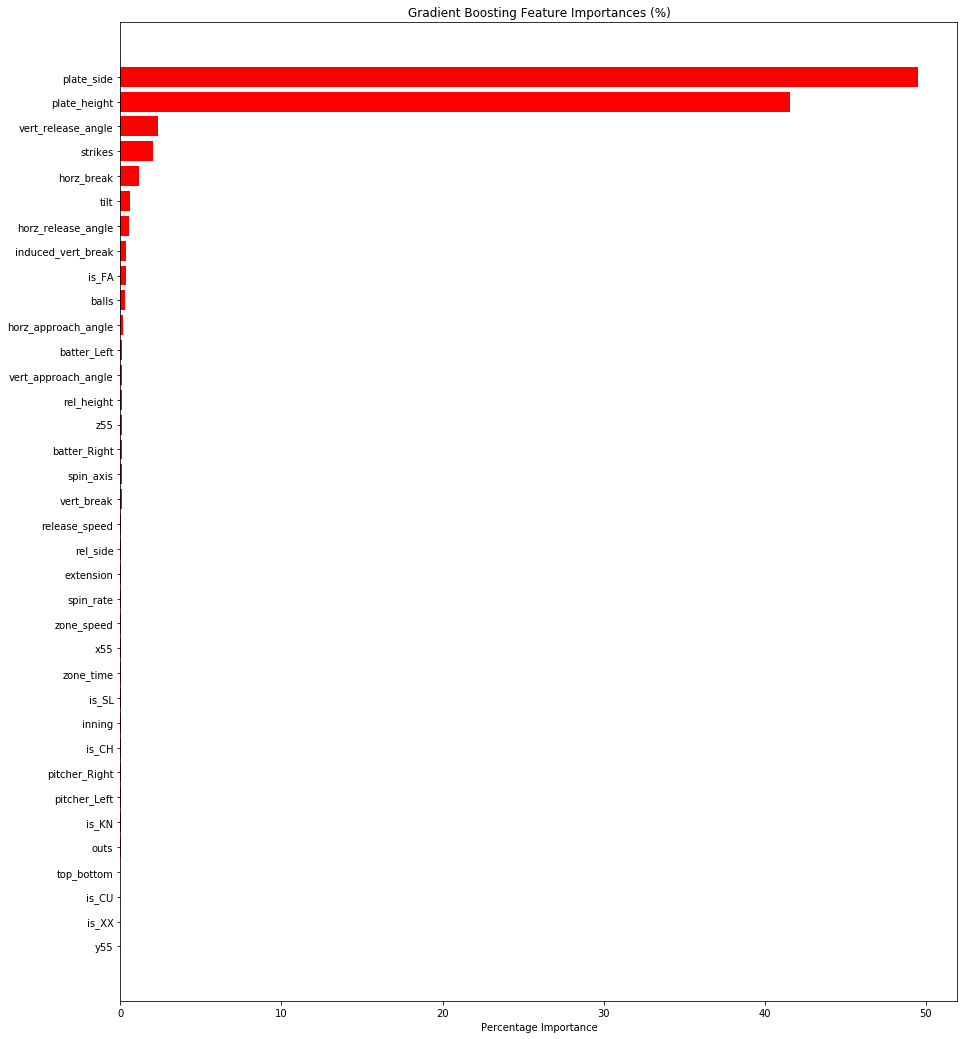

In [32]:
gboost = GradientBoostingClassifier(n_estimators=1000, random_state=11)
gboost.fit(X_train, y_train)
y_pred = gboost.predict(X_test)

print(f'Gboost train accuracy: {gboost.score(X_train, y_train)}')
print(f'Gboost test accuracy:  {gboost.score(X_test, y_test)}')
print('\n')
print(classification_report(y_test, y_pred))

feature_importances = pd.DataFrame(pd.Series(gboost.feature_importances_), columns=['Importance'])
feature_importances.index = X_train.columns
feature_importances = feature_importances.sort_values('Importance')

plt.figure(figsize=(15,18))
plt.barh(feature_importances.index, width=feature_importances['Importance'] * 100, color='r')
plt.title("Gradient Boosting Feature Importances (%)")
plt.xlabel('Percentage Importance')
plt.show()

Plate side and height were the two most important features to this model. Which makes sense. These two basically gave an X and Y coordinate on where the ball crossed the plate, so it would make sense that these two would be far and away the most important features. Another metric to judge here would be the model's PR graph, let's take a look at that.

In [33]:
y_probs = gboost.predict_proba(X_test)
y_probs = y_probs[:, 1]

gboost_precision, gboost_recall, _ = precision_recall_curve(y_test, y_probs)

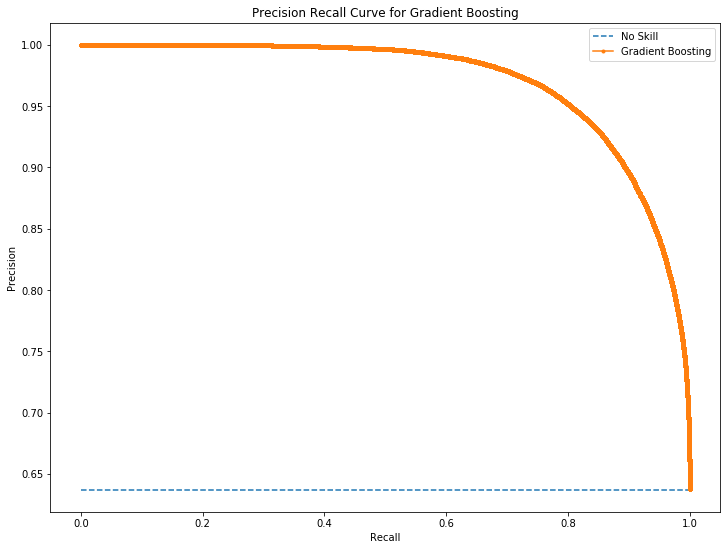

Gradient Boosting AUC Score: 0.9699183779450761


In [34]:
no_skill = len(y_test[y_test == 1]) / len(y_test)
plt.figure(figsize=(12,9))
plt.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')
plt.plot(gboost_recall, gboost_precision, marker='.', label='Gradient Boosting')
plt.title('Precision Recall Curve for Gradient Boosting')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.show()

print(f'Gradient Boosting AUC Score: {auc(gboost_recall, gboost_precision)}')

Pretty good precision-recall curve. The model has a good precision up until high recalls, when it starts to drop off. Also, a very good AUC score. This model had a 97% chance that it ranked a random positive sample higher than a random negative sample. Next thing to look at would be a precision recall curve.

Finally, another good metric to look at is the Mattew's Correlation Coefficient. The closer to 1 this metric is, the better correlation of predicitions this model had.

In [35]:
print(f'Matthew\'s Correlation Coefficient: {matthews_corrcoef(y_test, y_pred)}')

Matthew's Correlation Coefficient: 0.7173574995833374


## Making predictions on test set

We have a good model trained, now we can make predictions on the testing set. First we need to load it in and clean it the way we cleaned the training set.

In [36]:
test_df = pd.read_csv('../Data/2020-test.csv')

In [37]:
def clean_and_wrangle(df):
    
    df = df.drop(df[df['release_speed'].isnull()].index)
    df = df.drop(df[df['outs'].isnull()].index)
    df['spin_rate'].fillna(df['spin_rate'].mean(), inplace=True)
    df = df.drop(df[df['tilt'].isnull()].index)
    df = df.drop(df[df['pitch_type'].isnull()].index)
    df = df.reset_index().drop('index', axis=1)
    
    df['tilt'] = df['tilt'].map(lambda x: sum(a*int(t) for a, t in zip([3600, 60], x.split(':'))) \
                                          if ':' in x else int(x[:-5]))
    return df

In [38]:
test_df = clean_and_wrangle(test_df)

In [39]:
test_df.head(10)

,pitcher_id,pitcher_side,batter_id,batter_side,stadium_id,umpire_id,catcher_id,inning,top_bottom,outs,...,zone_speed,vert_approach_angle,horz_approach_angle,zone_time,x55,y55,z55,pitch_type,is_strike,pitch_id
0,d3396348,Left,d9b3bce2,Right,501b6728,a63083b5,c338c856,8,1,2.0,...,85.462196,-5.52951,0.682682,0.411072,2.65519,55,6.30581,FA,NaN,f2204560
1,4c807a49,Left,4aafd18a,Right,8d1f4cfc,93c9014b,97c420bc,1,2,1.0,...,76.937698,-7.24994,0.617254,0.446388,2.05217,55,5.89617,CH,NaN,4a16102e
2,18182a03,Right,c790fbeb,Left,075be90a,9c02aab4,568a8108,6,2,1.0,...,83.710899,-7.12427,-4.845640,0.421318,-1.78613,55,5.93421,SL,NaN,73ffabd3
3,94a20652,Right,bf921933,Right,934c75c6,043de890,5e710b9e,5,1,1.0,...,85.949799,-5.92277,-3.132810,0.400539,-1.56069,55,5.44192,FA,NaN,60ed54c3
4,4f3062b6,Left,65df5b42,Right,c9712626,d057fd71,00ae6fb5,3,1,1.0,...,85.592598,-7.10051,1.461540,0.406034,2.15070,55,6.43411,FA,NaN,5d720732
5,3903adfd,Right,13448018,Left,45b7bf7c,1ce4b3e6,fbc0970f,5,1,1.0,...,83.406601,-5.14624,0.550966,0.412397,-2.45849,55,6.32671,FA,NaN,4aa772e1
6,d9b3bce2,Right,1817dec7,Left,075be90a,0c8846f2,370c45c8,7,1,0.0,...,84.818802,-4.38852,-1.782670,0.405944,-2.91866,55,5.86711,FA,NaN,debae10c
7,06e0842e,Left,730d2dbf,Left,20418ce9,852c6a22,65b01821,6,2,1.0,...,82.629601,-5.51211,1.447130,0.423868,2.04815,55,5.84246,FA,NaN,c71b9d22
8,fe5717f2,Right,44c206bb,Right,fe6b0f40,16750c18,62542678,6,1,2.0,...,86.618500,-4.40207,-0.125200,0.397941,-1.50450,55,6.53886,FA,NaN,fd77d5fb
9,7fa6b7cb,Right,e5fe8773,Left,d0d69f32,c4c41d26,9d29b427,5,2,0.0,...,85.491203,-6.62900,-0.512073,0.403582,-2.67956,55,5.61784,FA,NaN,c43cd8b2


In [40]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145097 entries, 0 to 145096
Data columns (total 36 columns):
pitcher_id             145097 non-null object
pitcher_side           145097 non-null object
batter_id              145097 non-null object
batter_side            145097 non-null object
stadium_id             145097 non-null object
umpire_id              145097 non-null object
catcher_id             145097 non-null object
inning                 145097 non-null int64
top_bottom             145097 non-null int64
outs                   145097 non-null float64
balls                  145097 non-null int64
strikes                145097 non-null int64
release_speed          145097 non-null float64
vert_release_angle     145097 non-null float64
horz_release_angle     145097 non-null float64
spin_rate              145097 non-null float64
spin_axis              145097 non-null float64
tilt                   145097 non-null int64
rel_height             145097 non-null float64
rel_side     

No null values (except our target variable "is_strike"). We'll use our trained model from up above and make predictions on the entire testing set and insert those predictions into the data set.

In [41]:
X = test_df.drop(['pitcher_id', 'batter_id', 'stadium_id', 'umpire_id', 'catcher_id', 'is_strike', 'pitch_id'], axis=1)

X = pd.get_dummies(X, prefix=['pitcher', 'batter', 'is'], columns=['pitcher_side', 'batter_side', 'pitch_type'])

In [42]:
predictions = gboost.predict(X)

In [43]:
test_df['is_strike'] = predictions
test_df.head(10)

,pitcher_id,pitcher_side,batter_id,batter_side,stadium_id,umpire_id,catcher_id,inning,top_bottom,outs,...,zone_speed,vert_approach_angle,horz_approach_angle,zone_time,x55,y55,z55,pitch_type,is_strike,pitch_id
0,d3396348,Left,d9b3bce2,Right,501b6728,a63083b5,c338c856,8,1,2.0,...,85.462196,-5.52951,0.682682,0.411072,2.65519,55,6.30581,FA,0,f2204560
1,4c807a49,Left,4aafd18a,Right,8d1f4cfc,93c9014b,97c420bc,1,2,1.0,...,76.937698,-7.24994,0.617254,0.446388,2.05217,55,5.89617,CH,1,4a16102e
2,18182a03,Right,c790fbeb,Left,075be90a,9c02aab4,568a8108,6,2,1.0,...,83.710899,-7.12427,-4.845640,0.421318,-1.78613,55,5.93421,SL,0,73ffabd3
3,94a20652,Right,bf921933,Right,934c75c6,043de890,5e710b9e,5,1,1.0,...,85.949799,-5.92277,-3.132810,0.400539,-1.56069,55,5.44192,FA,0,60ed54c3
4,4f3062b6,Left,65df5b42,Right,c9712626,d057fd71,00ae6fb5,3,1,1.0,...,85.592598,-7.10051,1.461540,0.406034,2.15070,55,6.43411,FA,1,5d720732
5,3903adfd,Right,13448018,Left,45b7bf7c,1ce4b3e6,fbc0970f,5,1,1.0,...,83.406601,-5.14624,0.550966,0.412397,-2.45849,55,6.32671,FA,0,4aa772e1
6,d9b3bce2,Right,1817dec7,Left,075be90a,0c8846f2,370c45c8,7,1,0.0,...,84.818802,-4.38852,-1.782670,0.405944,-2.91866,55,5.86711,FA,1,debae10c
7,06e0842e,Left,730d2dbf,Left,20418ce9,852c6a22,65b01821,6,2,1.0,...,82.629601,-5.51211,1.447130,0.423868,2.04815,55,5.84246,FA,1,c71b9d22
8,fe5717f2,Right,44c206bb,Right,fe6b0f40,16750c18,62542678,6,1,2.0,...,86.618500,-4.40207,-0.125200,0.397941,-1.50450,55,6.53886,FA,1,fd77d5fb
9,7fa6b7cb,Right,e5fe8773,Left,d0d69f32,c4c41d26,9d29b427,5,2,0.0,...,85.491203,-6.62900,-0.512073,0.403582,-2.67956,55,5.61784,FA,1,c43cd8b2


# Conclusion

Overall we created a good model to predict if a specific pitch was going to be a strike or not. We started off by cleaning the data set and making sure that no null values were in the table. Next we had to create the target variable from a column that already existed in the data set. Finally had to wrangle some data to get it all in the correct format to be suitable to run a machine learning model on. Using gradient boosting, tuned its n_estimators parameter, and settled on 1000 as the number of estimators we were going to use for making predictions on the full data set. After making predictions, we needed to make sure the model was performing well, and took a look at a number of different metrics for model performance. Accuracy, the classification report, AUC score, and Matthew's Correlation Coefficient all agreed that this model we built was well suited for predicting strikes. We also took a look at the most important features of the model, and came away with plate side and plate height being the most important features.

If I had more time and resources to dedicate to this project, I would have used cross validation to automatically have the best number of estimators chosen for me. I would have also liked to tune the max_depth hyperparameter, so tuning max_depth and n_estimators in a pipeline with GridSearchCV would have been my ideal way of hyperparameter tuning the model.